In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
def convolve2D(image, kernel):
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape

    pad_height = kernel_height // 2
    pad_width = kernel_width // 2

    padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant')
    output = np.zeros_like(image)

    for i in range(image_height):
        for j in range(image_width):
            region = padded_image[i:i+kernel_height, j:j+kernel_width]
            output[i, j] = np.sum(region * kernel)

    output = np.clip(output, 0, 255)

    return output

In [ ]:
image_path = '/content/einstein.jpg'
image = Image.open(image_path).convert('L')
image_array = np.array(image)

In [ ]:
print("Image: \n")
print(image_array)

Image: 

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [ 16  17  17 ... 254 254 255]
 [ 13  13  13 ... 255 255 255]
 [  9   9  10 ... 255 255 255]]


In [ ]:
edge_detection_filter = np.array([
    [-1, -1, -1],
    [-1,  8, -1],
    [-1, -1, -1]])

In [ ]:
edges = convolve2D(image_array, edge_detection_filter)

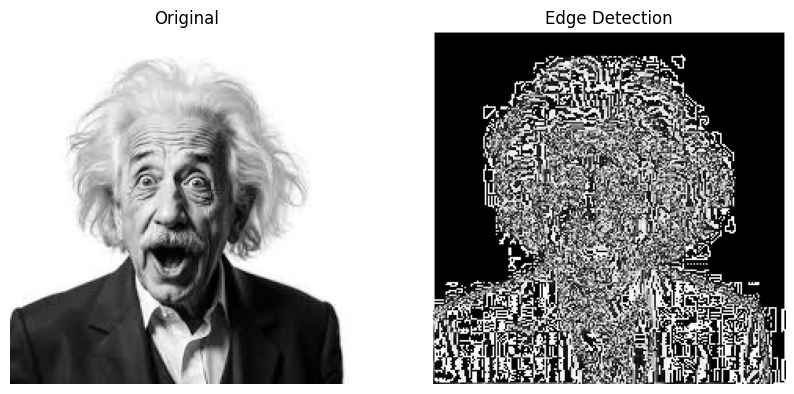

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(image_array, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Edge Detection")
plt.imshow(edges, cmap='gray')
plt.axis('off')

plt.show()

In [ ]:
print("Edges: \n")
print(edges)

Edges: 

[[251 253 253 ... 253 253 251]
 [253   0   0 ...   0   0 253]
 [253   0   0 ...   0   0 253]
 ...
 [ 41 254 251 ... 251 251 255]
 [ 40   0 253 ...   2   2 254]
 [ 37  14  21 ... 253 253 251]]


100%|██████████| 26.4M/26.4M [00:01<00:00, 15.2MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 266kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 4.96MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 12.4MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Epoch [1/5], Loss: 0.2252
Epoch [2/5], Loss: 0.2133
Epoch [3/5], Loss: 0.5103
Epoch [4/5], Loss: 0.3991
Epoch [5/5], Loss: 0.4441
Accuracy: 90.38%
Classification Report:
               precision    recall  f1-score   support

 T-shirt/top     0.8294    0.8800    0.8540      1000
     Trouser     0.9810    0.9830    0.9820      1000
    Pullover     0.8573    0.8410    0.8491      1000
       Dress     0.9124    0.8960    0.9041      1000
        Coat     0.8201    0.8800    0.8490      1000
      Sandal     0.9850    0.9820    0.9835      1000
       Shirt     0.7657    0.6700    0.7147      1000
     Sneaker     0.9290    0.9810    0.9543      1000
         Bag     0.9667    0.9860    0.9762      1000
  Ankle boot     0.9853    0.9390    0.9616      1000

    accuracy                         0.9038     10000
   macro avg     0.9032    0.9038    0.9028     10000
weighted avg     0.9032    0.9038   

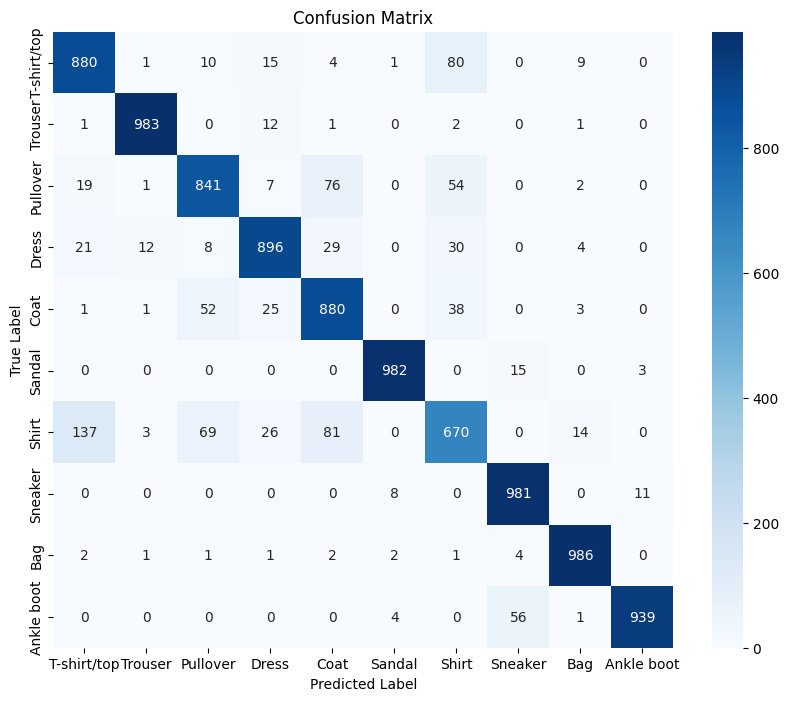

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_epochs = 5
batch_size = 64
learning_rate = 0.001

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

accuracy = np.mean(np.array(all_labels) == np.array(all_preds))
report = classification_report(all_labels, all_preds, target_names=test_dataset.classes, digits=4)
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:\n", report)

plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
